In [2]:
import os
import ast
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import tensorflow as tf
import pickle
# from tensorflow.contrib import lite
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l1, l2, l1_l2
from keras.utils import np_utils
from keras.models import load_model
from keras import backend as K
import random
from random import randrange

# %matplotlib notebook

c:\users\cesar\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\cesar\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\cesar\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\cesar\appd

In [2]:
def indices_to_one_hot(letra, nb_classes):
    # Gera um dicionário de mapeamento de letra em valor inteiro (a->0, b->1, ..., w->20)
    dic_conv = {}
    for i,letra in enumerate(letras):
        dic_conv[letra] = i
    
    num = dic_conv[letra]
    return [[0 if i!=num else 1 for i in range(nb_classes)]]


def get_incorrects(model, data, labels):
    p = model.predict(data)
    
    errors = []
    for i in range(len(data)):
        equal = (np.where(labels[i] == np.amax(labels[i]))[0][0]) == (np.where(p[i] == np.amax(p[i])))[0][0]
        if not equal:
            print((np.where(labels[i] == np.amax(labels[i]))[0][0]), (np.where(p[i] == np.amax(p[i])))[0][0])
            print()
            errors.append(i)
        
    print(len(errors))
    return errors


def test_file(model, file_name):
    letra = file_name[0].lower()
    dataset_test = pd.DataFrame()

    with open(file_name) as file:
        lines_test = [l.strip() for l in file]
        lines_test = ast.literal_eval(lines_test[0])
        temp = pd.DataFrame(lines_test)
        temp['label'] = 'c'
        dataset_test = dataset_test.append(temp, ignore_index = True)

    X_DT = dataset_test.iloc[:,0:30] # [all rows, col from index 2 to the last one excludind 'label']
    X_DT = X_DT/32768

    # Tranform training labels to one-hot encoding
    y_DT = indices_to_one_hot(letra,20)

    y_DT = y_DT*100
    
    errors = get_incorrects(model, X_DT, y_DT)
    return errors


def print_acc_results(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
#     plt.title('Resultados no treinamento')
    plt.ylabel('Acurácia')
    plt.xlabel('Época')
    plt.legend(['Treinamento', 'Teste'], loc='best')
    plt.grid()
#     plt.ylim((0, 1)) 
    plt.show()


def print_loss_results(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
#     plt.title('Resultados no teste')
    plt.ylabel('Entropia Cruzada')
    plt.xlabel('Época')
    plt.legend(['Treinamento', 'Teste'], loc='best')
    plt.grid()
#     plt.ylim((0, 10)) 
    plt.show()

In [8]:
X_train = pd.read_csv("mini_dataset_train.csv")
X_val = pd.read_csv('mini_dataset_validation.csv')

X_train = X_train.iloc[:,1:31]
X_val = X_val.iloc[:,1:31]

y_train = np.loadtxt("labels_train.csv", delimiter=",")
y_val = np.loadtxt("labels_validation.csv", delimiter=",")

In [3]:
X_train = pd.read_csv("dataset_train.csv")

In [13]:
len(y_train[0])

27

In [ ]:
from keras.layers import Layer
from keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
#         print(input_shape)
#         print(self.units)
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [11]:
# for neurons in range(1,51):
neurons = 20
model = Sequential()

classes = 27
# hidden_layers = 0
# neurons = [25] * hidden_layers
# neurons = 1
epochs = 10000

# Camada de entrada
model.add(Dense(units=neurons, activation='sigmoid', input_dim=30))

model.add(Dense(units=10, activation='sigmoid'))
# model.add(Dropout(0.2))
# Camadas escondidas
# for i in range(hidden_layers):
#     model.add(Dense(units=neurons[i], activation='sigmoid'))

# Camada de saída\
model.add(Dense(units=classes, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=epochs, batch_size = 20, validation_data=(X_val, y_val), verbose=1)
loss, accuracy = model.evaluate(X_val, y_val)

with open('variacao_neuronios_completo/' + str(neurons) + '_neurons.pickle', 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# model.save('modelo_alfabeto_treinado.h5')

Train on 216 samples, validate on 54 samples
Epoch 1/10000
216/216 [==============================] - 0s 2ms/step - loss: 3.3383 - acc: 0.0231 - val_loss: 3.3256 - val_acc: 0.0185
Epoch 2/10000
216/216 [==============================] - 0s 111us/step - loss: 3.3250 - acc: 0.0417 - val_loss: 3.3243 - val_acc: 0.0185
Epoch 3/10000
216/216 [==============================] - 0s 97us/step - loss: 3.3167 - acc: 0.0417 - val_loss: 3.3231 - val_acc: 0.0185
Epoch 4/10000
216/216 [==============================] - 0s 88us/step - loss: 3.3101 - acc: 0.0417 - val_loss: 3.3225 - val_acc: 0.0185
Epoch 5/10000
216/216 [==============================] - 0s 106us/step - loss: 3.3041 - acc: 0.0417 - val_loss: 3.3219 - val_acc: 0.0185
Epoch 6/10000
216/216 [==============================] - 0s 97us/step - loss: 3.2991 - acc: 0.0417 - val_loss: 3.3212 - val_acc: 0.0185
Epoch 7/10000
216/216 [==============================] - 0s 88us/step - loss: 3.2949 - acc: 0.0417 - val_loss: 3.3204 - val_acc: 0.0185
Ep

216/216 [==============================] - 0s 93us/step - loss: 2.3411 - acc: 0.4352 - val_loss: 2.4443 - val_acc: 0.4074
Epoch 120/10000
216/216 [==============================] - 0s 93us/step - loss: 2.3317 - acc: 0.4583 - val_loss: 2.4345 - val_acc: 0.4074
Epoch 121/10000
216/216 [==============================] - 0s 120us/step - loss: 2.3228 - acc: 0.4491 - val_loss: 2.4241 - val_acc: 0.4074
Epoch 122/10000
216/216 [==============================] - 0s 97us/step - loss: 2.3133 - acc: 0.4583 - val_loss: 2.4143 - val_acc: 0.4074
Epoch 123/10000
216/216 [==============================] - 0s 93us/step - loss: 2.3043 - acc: 0.4583 - val_loss: 2.4045 - val_acc: 0.4074
Epoch 124/10000
216/216 [==============================] - 0s 106us/step - loss: 2.2947 - acc: 0.4676 - val_loss: 2.3951 - val_acc: 0.4259
Epoch 125/10000
216/216 [==============================] - 0s 111us/step - loss: 2.2856 - acc: 0.4861 - val_loss: 2.3857 - val_acc: 0.4259
Epoch 126/10000
216/216 [======================

216/216 [==============================] - 0s 148us/step - loss: 1.4418 - acc: 0.6852 - val_loss: 1.5458 - val_acc: 0.5926
Epoch 238/10000
216/216 [==============================] - 0s 111us/step - loss: 1.4369 - acc: 0.6852 - val_loss: 1.5405 - val_acc: 0.5926
Epoch 239/10000
216/216 [==============================] - 0s 134us/step - loss: 1.4314 - acc: 0.6944 - val_loss: 1.5356 - val_acc: 0.5926
Epoch 240/10000
216/216 [==============================] - 0s 148us/step - loss: 1.4260 - acc: 0.6898 - val_loss: 1.5303 - val_acc: 0.5926
Epoch 241/10000
216/216 [==============================] - 0s 148us/step - loss: 1.4202 - acc: 0.6944 - val_loss: 1.5254 - val_acc: 0.5926
Epoch 242/10000
216/216 [==============================] - 0s 120us/step - loss: 1.4150 - acc: 0.6991 - val_loss: 1.5200 - val_acc: 0.5926
Epoch 243/10000
216/216 [==============================] - 0s 106us/step - loss: 1.4094 - acc: 0.6991 - val_loss: 1.5144 - val_acc: 0.5926
Epoch 244/10000
216/216 [==================

216/216 [==============================] - 0s 130us/step - loss: 0.9776 - acc: 0.7500 - val_loss: 1.1021 - val_acc: 0.6296
Epoch 356/10000
216/216 [==============================] - 0s 143us/step - loss: 0.9748 - acc: 0.7454 - val_loss: 1.0991 - val_acc: 0.6296
Epoch 357/10000
216/216 [==============================] - 0s 167us/step - loss: 0.9715 - acc: 0.7500 - val_loss: 1.0961 - val_acc: 0.6296
Epoch 358/10000
216/216 [==============================] - 0s 134us/step - loss: 0.9692 - acc: 0.7546 - val_loss: 1.0944 - val_acc: 0.6296
Epoch 359/10000
216/216 [==============================] - 0s 134us/step - loss: 0.9659 - acc: 0.7454 - val_loss: 1.0919 - val_acc: 0.6296
Epoch 360/10000
216/216 [==============================] - 0s 130us/step - loss: 0.9636 - acc: 0.7454 - val_loss: 1.0890 - val_acc: 0.6296
Epoch 361/10000
216/216 [==============================] - 0s 130us/step - loss: 0.9603 - acc: 0.7593 - val_loss: 1.0867 - val_acc: 0.6296
Epoch 362/10000
216/216 [==================

216/216 [==============================] - 0s 102us/step - loss: 0.6939 - acc: 0.8333 - val_loss: 0.8229 - val_acc: 0.6667
Epoch 474/10000
216/216 [==============================] - 0s 102us/step - loss: 0.6922 - acc: 0.8287 - val_loss: 0.8211 - val_acc: 0.6667
Epoch 475/10000
216/216 [==============================] - 0s 102us/step - loss: 0.6905 - acc: 0.8287 - val_loss: 0.8194 - val_acc: 0.6667
Epoch 476/10000
216/216 [==============================] - 0s 93us/step - loss: 0.6879 - acc: 0.8333 - val_loss: 0.8171 - val_acc: 0.6667
Epoch 477/10000
216/216 [==============================] - 0s 97us/step - loss: 0.6863 - acc: 0.8333 - val_loss: 0.8151 - val_acc: 0.6667
Epoch 478/10000
216/216 [==============================] - 0s 97us/step - loss: 0.6842 - acc: 0.8287 - val_loss: 0.8132 - val_acc: 0.6667
Epoch 479/10000
216/216 [==============================] - 0s 116us/step - loss: 0.6823 - acc: 0.8333 - val_loss: 0.8113 - val_acc: 0.6667
Epoch 480/10000
216/216 [=====================

Epoch 591/10000
216/216 [==============================] - 0s 120us/step - loss: 0.4959 - acc: 0.8843 - val_loss: 0.6296 - val_acc: 0.8148
Epoch 592/10000
216/216 [==============================] - 0s 97us/step - loss: 0.4944 - acc: 0.8796 - val_loss: 0.6280 - val_acc: 0.8148
Epoch 593/10000
216/216 [==============================] - 0s 97us/step - loss: 0.4933 - acc: 0.8843 - val_loss: 0.6262 - val_acc: 0.8148
Epoch 594/10000
216/216 [==============================] - 0s 97us/step - loss: 0.4917 - acc: 0.8843 - val_loss: 0.6265 - val_acc: 0.8148
Epoch 595/10000
216/216 [==============================] - 0s 167us/step - loss: 0.4905 - acc: 0.8843 - val_loss: 0.6249 - val_acc: 0.8148
Epoch 596/10000
216/216 [==============================] - 0s 134us/step - loss: 0.4893 - acc: 0.8796 - val_loss: 0.6237 - val_acc: 0.8148
Epoch 597/10000
216/216 [==============================] - 0s 116us/step - loss: 0.4878 - acc: 0.8796 - val_loss: 0.6226 - val_acc: 0.8148
Epoch 598/10000
216/216 [=====

216/216 [==============================] - 0s 93us/step - loss: 0.4220 - acc: 0.8981 - val_loss: 0.5616 - val_acc: 0.8519
Epoch 651/10000
216/216 [==============================] - 0s 106us/step - loss: 0.4212 - acc: 0.8981 - val_loss: 0.5603 - val_acc: 0.8519
Epoch 652/10000
216/216 [==============================] - 0s 88us/step - loss: 0.4202 - acc: 0.8981 - val_loss: 0.5586 - val_acc: 0.8519
Epoch 653/10000
216/216 [==============================] - 0s 88us/step - loss: 0.4183 - acc: 0.8981 - val_loss: 0.5576 - val_acc: 0.8519
Epoch 654/10000
216/216 [==============================] - 0s 93us/step - loss: 0.4178 - acc: 0.8981 - val_loss: 0.5572 - val_acc: 0.8519
Epoch 655/10000
216/216 [==============================] - 0s 102us/step - loss: 0.4162 - acc: 0.9074 - val_loss: 0.5564 - val_acc: 0.8519
Epoch 656/10000
216/216 [==============================] - 0s 93us/step - loss: 0.4156 - acc: 0.9028 - val_loss: 0.5544 - val_acc: 0.8519
Epoch 657/10000
216/216 [=======================

216/216 [==============================] - 0s 97us/step - loss: 0.3075 - acc: 0.9444 - val_loss: 0.4639 - val_acc: 0.8704
Epoch 769/10000
216/216 [==============================] - 0s 102us/step - loss: 0.3069 - acc: 0.9444 - val_loss: 0.4630 - val_acc: 0.8704
Epoch 770/10000
216/216 [==============================] - 0s 93us/step - loss: 0.3058 - acc: 0.9444 - val_loss: 0.4616 - val_acc: 0.8704
Epoch 771/10000
216/216 [==============================] - 0s 111us/step - loss: 0.3049 - acc: 0.9444 - val_loss: 0.4617 - val_acc: 0.8704
Epoch 772/10000
216/216 [==============================] - 0s 97us/step - loss: 0.3040 - acc: 0.9398 - val_loss: 0.4624 - val_acc: 0.8704
Epoch 773/10000
216/216 [==============================] - 0s 97us/step - loss: 0.3031 - acc: 0.9444 - val_loss: 0.4617 - val_acc: 0.8704
Epoch 774/10000
216/216 [==============================] - 0s 139us/step - loss: 0.3026 - acc: 0.9444 - val_loss: 0.4602 - val_acc: 0.8704
Epoch 775/10000
216/216 [======================

216/216 [==============================] - 0s 97us/step - loss: 0.2211 - acc: 0.9676 - val_loss: 0.4042 - val_acc: 0.9259
Epoch 887/10000
216/216 [==============================] - 0s 93us/step - loss: 0.2204 - acc: 0.9676 - val_loss: 0.4027 - val_acc: 0.9259
Epoch 888/10000
216/216 [==============================] - 0s 93us/step - loss: 0.2201 - acc: 0.9676 - val_loss: 0.4026 - val_acc: 0.9259
Epoch 889/10000
216/216 [==============================] - 0s 102us/step - loss: 0.2190 - acc: 0.9676 - val_loss: 0.4027 - val_acc: 0.9259
Epoch 890/10000
216/216 [==============================] - 0s 93us/step - loss: 0.2187 - acc: 0.9676 - val_loss: 0.4030 - val_acc: 0.9259
Epoch 891/10000
216/216 [==============================] - 0s 88us/step - loss: 0.2184 - acc: 0.9676 - val_loss: 0.4014 - val_acc: 0.9259
Epoch 892/10000
216/216 [==============================] - 0s 88us/step - loss: 0.2172 - acc: 0.9676 - val_loss: 0.4015 - val_acc: 0.9259
Epoch 893/10000
216/216 [========================

216/216 [==============================] - 0s 130us/step - loss: 0.1579 - acc: 0.9676 - val_loss: 0.3745 - val_acc: 0.9259
Epoch 1005/10000
216/216 [==============================] - 0s 125us/step - loss: 0.1575 - acc: 0.9676 - val_loss: 0.3742 - val_acc: 0.9259
Epoch 1006/10000
216/216 [==============================] - 0s 134us/step - loss: 0.1575 - acc: 0.9676 - val_loss: 0.3753 - val_acc: 0.9259
Epoch 1007/10000
216/216 [==============================] - 0s 139us/step - loss: 0.1568 - acc: 0.9676 - val_loss: 0.3749 - val_acc: 0.9259
Epoch 1008/10000
216/216 [==============================] - 0s 125us/step - loss: 0.1561 - acc: 0.9676 - val_loss: 0.3756 - val_acc: 0.9259
Epoch 1009/10000
216/216 [==============================] - 0s 116us/step - loss: 0.1561 - acc: 0.9676 - val_loss: 0.3761 - val_acc: 0.9259
Epoch 1010/10000
216/216 [==============================] - 0s 116us/step - loss: 0.1557 - acc: 0.9676 - val_loss: 0.3746 - val_acc: 0.9259
Epoch 1011/10000
216/216 [===========

Epoch 1063/10000
216/216 [==============================] - 0s 88us/step - loss: 0.1343 - acc: 0.9676 - val_loss: 0.3753 - val_acc: 0.9259
Epoch 1064/10000
216/216 [==============================] - 0s 97us/step - loss: 0.1339 - acc: 0.9676 - val_loss: 0.3755 - val_acc: 0.9259
Epoch 1065/10000
216/216 [==============================] - 0s 102us/step - loss: 0.1339 - acc: 0.9676 - val_loss: 0.3756 - val_acc: 0.9074
Epoch 1066/10000
216/216 [==============================] - 0s 97us/step - loss: 0.1333 - acc: 0.9676 - val_loss: 0.3749 - val_acc: 0.9074
Epoch 1067/10000
216/216 [==============================] - 0s 88us/step - loss: 0.1330 - acc: 0.9676 - val_loss: 0.3737 - val_acc: 0.9074
Epoch 1068/10000
216/216 [==============================] - 0s 93us/step - loss: 0.1322 - acc: 0.9676 - val_loss: 0.3730 - val_acc: 0.9259
Epoch 1069/10000
216/216 [==============================] - 0s 102us/step - loss: 0.1327 - acc: 0.9722 - val_loss: 0.3740 - val_acc: 0.9259
Epoch 1070/10000
216/216 

Epoch 1122/10000
216/216 [==============================] - 0s 93us/step - loss: 0.1144 - acc: 0.9722 - val_loss: 0.3777 - val_acc: 0.8889
Epoch 1123/10000
216/216 [==============================] - 0s 102us/step - loss: 0.1139 - acc: 0.9769 - val_loss: 0.3785 - val_acc: 0.8889
Epoch 1124/10000
216/216 [==============================] - ETA: 0s - loss: 0.1310 - acc: 0.950 - 0s 93us/step - loss: 0.1137 - acc: 0.9722 - val_loss: 0.3793 - val_acc: 0.8889
Epoch 1125/10000
216/216 [==============================] - 0s 88us/step - loss: 0.1133 - acc: 0.9722 - val_loss: 0.3796 - val_acc: 0.8889
Epoch 1126/10000
216/216 [==============================] - 0s 97us/step - loss: 0.1129 - acc: 0.9722 - val_loss: 0.3795 - val_acc: 0.8889
Epoch 1127/10000
216/216 [==============================] - 0s 102us/step - loss: 0.1129 - acc: 0.9722 - val_loss: 0.3802 - val_acc: 0.8889
Epoch 1128/10000
216/216 [==============================] - 0s 97us/step - loss: 0.1123 - acc: 0.9722 - val_loss: 0.3807 - val

Epoch 1239/10000
216/216 [==============================] - 0s 102us/step - loss: 0.0831 - acc: 0.9815 - val_loss: 0.4061 - val_acc: 0.8889
Epoch 1240/10000
216/216 [==============================] - 0s 88us/step - loss: 0.0829 - acc: 0.9815 - val_loss: 0.4047 - val_acc: 0.8889
Epoch 1241/10000
216/216 [==============================] - 0s 102us/step - loss: 0.0823 - acc: 0.9815 - val_loss: 0.4028 - val_acc: 0.8889
Epoch 1242/10000
216/216 [==============================] - 0s 130us/step - loss: 0.0822 - acc: 0.9815 - val_loss: 0.4009 - val_acc: 0.8889
Epoch 1243/10000
216/216 [==============================] - 0s 93us/step - loss: 0.0820 - acc: 0.9815 - val_loss: 0.4020 - val_acc: 0.8889
Epoch 1244/10000
216/216 [==============================] - 0s 102us/step - loss: 0.0817 - acc: 0.9861 - val_loss: 0.4024 - val_acc: 0.8889
Epoch 1245/10000
216/216 [==============================] - 0s 88us/step - loss: 0.0815 - acc: 0.9815 - val_loss: 0.4031 - val_acc: 0.8889
Epoch 1246/10000
216/21

Epoch 1298/10000
216/216 [==============================] - 0s 102us/step - loss: 0.0703 - acc: 0.9907 - val_loss: 0.4184 - val_acc: 0.9074
Epoch 1299/10000
216/216 [==============================] - 0s 97us/step - loss: 0.0699 - acc: 0.9907 - val_loss: 0.4234 - val_acc: 0.9074
Epoch 1300/10000
216/216 [==============================] - 0s 88us/step - loss: 0.0695 - acc: 0.9907 - val_loss: 0.4220 - val_acc: 0.9074
Epoch 1301/10000
216/216 [==============================] - 0s 93us/step - loss: 0.0695 - acc: 0.9907 - val_loss: 0.4187 - val_acc: 0.9074
Epoch 1302/10000
216/216 [==============================] - 0s 97us/step - loss: 0.0692 - acc: 0.9907 - val_loss: 0.4182 - val_acc: 0.9074
Epoch 1303/10000
216/216 [==============================] - 0s 97us/step - loss: 0.0691 - acc: 0.9907 - val_loss: 0.4184 - val_acc: 0.9074
Epoch 1304/10000
216/216 [==============================] - 0s 93us/step - loss: 0.0691 - acc: 0.9907 - val_loss: 0.4199 - val_acc: 0.9074
Epoch 1305/10000
216/216 [

Epoch 1415/10000
216/216 [==============================] - 0s 88us/step - loss: 0.0464 - acc: 1.0000 - val_loss: 0.4673 - val_acc: 0.9074
Epoch 1416/10000
216/216 [==============================] - 0s 83us/step - loss: 0.0461 - acc: 1.0000 - val_loss: 0.4689 - val_acc: 0.9074
Epoch 1417/10000
216/216 [==============================] - 0s 88us/step - loss: 0.0462 - acc: 1.0000 - val_loss: 0.4703 - val_acc: 0.9074
Epoch 1418/10000
216/216 [==============================] - 0s 83us/step - loss: 0.0459 - acc: 1.0000 - val_loss: 0.4708 - val_acc: 0.9074
Epoch 1419/10000
216/216 [==============================] - 0s 79us/step - loss: 0.0457 - acc: 1.0000 - val_loss: 0.4722 - val_acc: 0.9074
Epoch 1420/10000
216/216 [==============================] - 0s 93us/step - loss: 0.0456 - acc: 1.0000 - val_loss: 0.4689 - val_acc: 0.9074
Epoch 1421/10000
216/216 [==============================] - 0s 97us/step - loss: 0.0453 - acc: 1.0000 - val_loss: 0.4700 - val_acc: 0.9074
Epoch 1422/10000
216/216 [=

Epoch 1474/10000
216/216 [==============================] - 0s 88us/step - loss: 0.0378 - acc: 1.0000 - val_loss: 0.4933 - val_acc: 0.9074
Epoch 1475/10000
216/216 [==============================] - 0s 83us/step - loss: 0.0376 - acc: 1.0000 - val_loss: 0.4965 - val_acc: 0.9074
Epoch 1476/10000
216/216 [==============================] - 0s 83us/step - loss: 0.0374 - acc: 1.0000 - val_loss: 0.4977 - val_acc: 0.9074
Epoch 1477/10000
216/216 [==============================] - 0s 93us/step - loss: 0.0375 - acc: 1.0000 - val_loss: 0.4981 - val_acc: 0.9074
Epoch 1478/10000
216/216 [==============================] - 0s 83us/step - loss: 0.0372 - acc: 1.0000 - val_loss: 0.4976 - val_acc: 0.9074
Epoch 1479/10000
216/216 [==============================] - 0s 83us/step - loss: 0.0372 - acc: 1.0000 - val_loss: 0.4968 - val_acc: 0.9074
Epoch 1480/10000
216/216 [==============================] - 0s 83us/step - loss: 0.0370 - acc: 1.0000 - val_loss: 0.4979 - val_acc: 0.9074
Epoch 1481/10000
216/216 [=

Epoch 1533/10000
216/216 [==============================] - 0s 93us/step - loss: 0.0308 - acc: 1.0000 - val_loss: 0.5208 - val_acc: 0.9074
Epoch 1534/10000
216/216 [==============================] - 0s 102us/step - loss: 0.0306 - acc: 1.0000 - val_loss: 0.5211 - val_acc: 0.9074
Epoch 1535/10000
216/216 [==============================] - 0s 162us/step - loss: 0.0306 - acc: 1.0000 - val_loss: 0.5234 - val_acc: 0.9074
Epoch 1536/10000
216/216 [==============================] - 0s 97us/step - loss: 0.0305 - acc: 1.0000 - val_loss: 0.5232 - val_acc: 0.9074
Epoch 1537/10000
216/216 [==============================] - 0s 120us/step - loss: 0.0304 - acc: 1.0000 - val_loss: 0.5251 - val_acc: 0.9074
Epoch 1538/10000
216/216 [==============================] - 0s 88us/step - loss: 0.0302 - acc: 1.0000 - val_loss: 0.5242 - val_acc: 0.9074
Epoch 1539/10000
216/216 [==============================] - 0s 102us/step - loss: 0.0302 - acc: 1.0000 - val_loss: 0.5228 - val_acc: 0.9074
Epoch 1540/10000
216/21

Epoch 1592/10000
216/216 [==============================] - 0s 97us/step - loss: 0.0249 - acc: 1.0000 - val_loss: 0.5446 - val_acc: 0.9074
Epoch 1593/10000
216/216 [==============================] - 0s 93us/step - loss: 0.0249 - acc: 1.0000 - val_loss: 0.5444 - val_acc: 0.9074
Epoch 1594/10000
216/216 [==============================] - 0s 88us/step - loss: 0.0247 - acc: 1.0000 - val_loss: 0.5469 - val_acc: 0.9074
Epoch 1595/10000
216/216 [==============================] - 0s 93us/step - loss: 0.0247 - acc: 1.0000 - val_loss: 0.5440 - val_acc: 0.9074
Epoch 1596/10000
216/216 [==============================] - 0s 120us/step - loss: 0.0246 - acc: 1.0000 - val_loss: 0.5455 - val_acc: 0.9074
Epoch 1597/10000
216/216 [==============================] - 0s 106us/step - loss: 0.0243 - acc: 1.0000 - val_loss: 0.5491 - val_acc: 0.9074
Epoch 1598/10000
216/216 [==============================] - 0s 106us/step - loss: 0.0243 - acc: 1.0000 - val_loss: 0.5467 - val_acc: 0.9074
Epoch 1599/10000
216/216

Epoch 1651/10000
216/216 [==============================] - 0s 153us/step - loss: 0.0199 - acc: 1.0000 - val_loss: 0.5743 - val_acc: 0.9074
Epoch 1652/10000
216/216 [==============================] - 0s 125us/step - loss: 0.0199 - acc: 1.0000 - val_loss: 0.5761 - val_acc: 0.9074
Epoch 1653/10000
216/216 [==============================] - 0s 102us/step - loss: 0.0199 - acc: 1.0000 - val_loss: 0.5706 - val_acc: 0.9074
Epoch 1654/10000
216/216 [==============================] - 0s 97us/step - loss: 0.0197 - acc: 1.0000 - val_loss: 0.5705 - val_acc: 0.9074
Epoch 1655/10000
216/216 [==============================] - 0s 139us/step - loss: 0.0198 - acc: 1.0000 - val_loss: 0.5710 - val_acc: 0.9074
Epoch 1656/10000
216/216 [==============================] - 0s 102us/step - loss: 0.0196 - acc: 1.0000 - val_loss: 0.5706 - val_acc: 0.9074
Epoch 1657/10000
216/216 [==============================] - 0s 111us/step - loss: 0.0196 - acc: 1.0000 - val_loss: 0.5741 - val_acc: 0.9074
Epoch 1658/10000
216/

Epoch 1768/10000
216/216 [==============================] - 0s 130us/step - loss: 0.0126 - acc: 1.0000 - val_loss: 0.6319 - val_acc: 0.9074
Epoch 1769/10000
216/216 [==============================] - 0s 185us/step - loss: 0.0126 - acc: 1.0000 - val_loss: 0.6290 - val_acc: 0.9074
Epoch 1770/10000
216/216 [==============================] - 0s 148us/step - loss: 0.0125 - acc: 1.0000 - val_loss: 0.6295 - val_acc: 0.9074
Epoch 1771/10000
216/216 [==============================] - 0s 139us/step - loss: 0.0125 - acc: 1.0000 - val_loss: 0.6310 - val_acc: 0.9074
Epoch 1772/10000
216/216 [==============================] - 0s 97us/step - loss: 0.0124 - acc: 1.0000 - val_loss: 0.6335 - val_acc: 0.9074
Epoch 1773/10000
216/216 [==============================] - 0s 134us/step - loss: 0.0124 - acc: 1.0000 - val_loss: 0.6347 - val_acc: 0.9074
Epoch 1774/10000
216/216 [==============================] - 0s 143us/step - loss: 0.0124 - acc: 1.0000 - val_loss: 0.6323 - val_acc: 0.9074
Epoch 1775/10000
216/

Epoch 1885/10000
216/216 [==============================] - 0s 93us/step - loss: 0.0077 - acc: 1.0000 - val_loss: 0.7016 - val_acc: 0.8889
Epoch 1886/10000
216/216 [==============================] - 0s 102us/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.7048 - val_acc: 0.8889
Epoch 1887/10000
216/216 [==============================] - 0s 93us/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.7066 - val_acc: 0.8889
Epoch 1888/10000
216/216 [==============================] - 0s 111us/step - loss: 0.0075 - acc: 1.0000 - val_loss: 0.7062 - val_acc: 0.8889
Epoch 1889/10000
216/216 [==============================] - 0s 93us/step - loss: 0.0075 - acc: 1.0000 - val_loss: 0.7074 - val_acc: 0.8889
Epoch 1890/10000
216/216 [==============================] - 0s 97us/step - loss: 0.0075 - acc: 1.0000 - val_loss: 0.7055 - val_acc: 0.8889
Epoch 1891/10000
216/216 [==============================] - 0s 93us/step - loss: 0.0074 - acc: 1.0000 - val_loss: 0.7083 - val_acc: 0.8889
Epoch 1892/10000
216/216 

Epoch 1944/10000
216/216 [==============================] - 0s 116us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.7535 - val_acc: 0.8889
Epoch 1945/10000
216/216 [==============================] - 0s 88us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.7546 - val_acc: 0.8889
Epoch 1946/10000
216/216 [==============================] - 0s 93us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.7520 - val_acc: 0.8889
Epoch 1947/10000
216/216 [==============================] - 0s 93us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.7529 - val_acc: 0.8889
Epoch 1948/10000
216/216 [==============================] - 0s 88us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.7550 - val_acc: 0.8889
Epoch 1949/10000
216/216 [==============================] - 0s 116us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.7551 - val_acc: 0.8889
Epoch 1950/10000
216/216 [==============================] - 0s 88us/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.7552 - val_acc: 0.8889
Epoch 1951/10000
216/216 

Epoch 2003/10000
216/216 [==============================] - 0s 111us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.8036 - val_acc: 0.8889
Epoch 2004/10000
216/216 [==============================] - 0s 116us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.8064 - val_acc: 0.8889
Epoch 2005/10000
216/216 [==============================] - 0s 148us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.8069 - val_acc: 0.8889
Epoch 2006/10000
216/216 [==============================] - 0s 116us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.8057 - val_acc: 0.8889
Epoch 2007/10000
216/216 [==============================] - 0s 97us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.8049 - val_acc: 0.8889
Epoch 2008/10000
216/216 [==============================] - 0s 88us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.8120 - val_acc: 0.8889
Epoch 2009/10000
216/216 [==============================] - 0s 106us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.8110 - val_acc: 0.8889
Epoch 2010/10000
216/2

Epoch 2120/10000
216/216 [==============================] - 0s 116us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.9237 - val_acc: 0.8889
Epoch 2121/10000
216/216 [==============================] - 0s 139us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.9223 - val_acc: 0.8889
Epoch 2122/10000
216/216 [==============================] - 0s 120us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.9273 - val_acc: 0.8889
Epoch 2123/10000
216/216 [==============================] - 0s 143us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.9275 - val_acc: 0.8889
Epoch 2124/10000
216/216 [==============================] - 0s 125us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.9247 - val_acc: 0.8889
Epoch 2125/10000
216/216 [==============================] - 0s 93us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.9290 - val_acc: 0.8889
Epoch 2126/10000
216/216 [==============================] - 0s 97us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.9323 - val_acc: 0.8889
Epoch 2127/10000
216/2

Epoch 2237/10000
216/216 [==============================] - 0s 93us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 1.0384 - val_acc: 0.8889
Epoch 2238/10000
216/216 [==============================] - 0s 102us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 1.0401 - val_acc: 0.8889
Epoch 2239/10000
216/216 [==============================] - 0s 130us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 1.0433 - val_acc: 0.8889
Epoch 2240/10000
216/216 [==============================] - 0s 116us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 1.0371 - val_acc: 0.8889
Epoch 2241/10000
216/216 [==============================] - 0s 139us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 1.0433 - val_acc: 0.8889
Epoch 2242/10000
216/216 [==============================] - 0s 185us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 1.0425 - val_acc: 0.8889
Epoch 2243/10000
216/216 [==============================] - 0s 134us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 1.0444 - val_acc: 0.8889
Epoch 2244/10000
216/

Epoch 2353/10000
216/216 [==============================] - 0s 93us/step - loss: 8.3371e-04 - acc: 1.0000 - val_loss: 1.1320 - val_acc: 0.8889
Epoch 2354/10000
216/216 [==============================] - 0s 125us/step - loss: 8.2315e-04 - acc: 1.0000 - val_loss: 1.1344 - val_acc: 0.8889
Epoch 2355/10000
216/216 [==============================] - 0s 116us/step - loss: 8.2017e-04 - acc: 1.0000 - val_loss: 1.1379 - val_acc: 0.8889
Epoch 2356/10000
216/216 [==============================] - 0s 143us/step - loss: 8.1601e-04 - acc: 1.0000 - val_loss: 1.1381 - val_acc: 0.8889
Epoch 2357/10000
216/216 [==============================] - 0s 139us/step - loss: 8.1100e-04 - acc: 1.0000 - val_loss: 1.1368 - val_acc: 0.8889
Epoch 2358/10000
216/216 [==============================] - 0s 130us/step - loss: 8.0914e-04 - acc: 1.0000 - val_loss: 1.1355 - val_acc: 0.8889
Epoch 2359/10000
216/216 [==============================] - 0s 106us/step - loss: 8.0324e-04 - acc: 1.0000 - val_loss: 1.1317 - val_acc: 

216/216 [==============================] - 0s 157us/step - loss: 6.1494e-04 - acc: 1.0000 - val_loss: 1.1767 - val_acc: 0.8889
Epoch 2411/10000
216/216 [==============================] - 0s 143us/step - loss: 6.1355e-04 - acc: 1.0000 - val_loss: 1.1785 - val_acc: 0.8889
Epoch 2412/10000
216/216 [==============================] - 0s 148us/step - loss: 6.0736e-04 - acc: 1.0000 - val_loss: 1.1766 - val_acc: 0.8889
Epoch 2413/10000
216/216 [==============================] - 0s 97us/step - loss: 6.0584e-04 - acc: 1.0000 - val_loss: 1.1743 - val_acc: 0.8889
Epoch 2414/10000
216/216 [==============================] - 0s 134us/step - loss: 6.0241e-04 - acc: 1.0000 - val_loss: 1.1737 - val_acc: 0.8889
Epoch 2415/10000
216/216 [==============================] - 0s 120us/step - loss: 5.9822e-04 - acc: 1.0000 - val_loss: 1.1761 - val_acc: 0.8889
Epoch 2416/10000
216/216 [==============================] - 0s 116us/step - loss: 5.9544e-04 - acc: 1.0000 - val_loss: 1.1754 - val_acc: 0.8889
Epoch 2417

216/216 [==============================] - 0s 97us/step - loss: 4.5179e-04 - acc: 1.0000 - val_loss: 1.2149 - val_acc: 0.8889
Epoch 2468/10000
216/216 [==============================] - 0s 97us/step - loss: 4.4959e-04 - acc: 1.0000 - val_loss: 1.2119 - val_acc: 0.8889
Epoch 2469/10000
216/216 [==============================] - 0s 134us/step - loss: 4.4686e-04 - acc: 1.0000 - val_loss: 1.2174 - val_acc: 0.8889
Epoch 2470/10000
216/216 [==============================] - 0s 102us/step - loss: 4.4366e-04 - acc: 1.0000 - val_loss: 1.2182 - val_acc: 0.8889
Epoch 2471/10000
216/216 [==============================] - 0s 106us/step - loss: 4.4220e-04 - acc: 1.0000 - val_loss: 1.2185 - val_acc: 0.8889
Epoch 2472/10000
216/216 [==============================] - 0s 111us/step - loss: 4.3996e-04 - acc: 1.0000 - val_loss: 1.2151 - val_acc: 0.8889
Epoch 2473/10000
216/216 [==============================] - 0s 106us/step - loss: 4.3687e-04 - acc: 1.0000 - val_loss: 1.2215 - val_acc: 0.8889
Epoch 2474/

216/216 [==============================] - 0s 97us/step - loss: 2.4633e-04 - acc: 1.0000 - val_loss: 1.2708 - val_acc: 0.8889
Epoch 2582/10000
216/216 [==============================] - 0s 116us/step - loss: 2.4485e-04 - acc: 1.0000 - val_loss: 1.2723 - val_acc: 0.8889
Epoch 2583/10000
216/216 [==============================] - 0s 102us/step - loss: 2.4278e-04 - acc: 1.0000 - val_loss: 1.2705 - val_acc: 0.8889
Epoch 2584/10000
216/216 [==============================] - 0s 93us/step - loss: 2.4214e-04 - acc: 1.0000 - val_loss: 1.2729 - val_acc: 0.8889
Epoch 2585/10000
216/216 [==============================] - 0s 97us/step - loss: 2.4133e-04 - acc: 1.0000 - val_loss: 1.2745 - val_acc: 0.8889
Epoch 2586/10000
216/216 [==============================] - 0s 102us/step - loss: 2.4006e-04 - acc: 1.0000 - val_loss: 1.2732 - val_acc: 0.8889
Epoch 2587/10000
216/216 [==============================] - 0s 106us/step - loss: 2.3857e-04 - acc: 1.0000 - val_loss: 1.2746 - val_acc: 0.8889
Epoch 2588/1

216/216 [==============================] - 0s 97us/step - loss: 1.3763e-04 - acc: 1.0000 - val_loss: 1.3051 - val_acc: 0.8889
Epoch 2696/10000
216/216 [==============================] - 0s 93us/step - loss: 1.3682e-04 - acc: 1.0000 - val_loss: 1.3011 - val_acc: 0.8889
Epoch 2697/10000
216/216 [==============================] - 0s 88us/step - loss: 1.3606e-04 - acc: 1.0000 - val_loss: 1.3010 - val_acc: 0.8889
Epoch 2698/10000
216/216 [==============================] - 0s 93us/step - loss: 1.3556e-04 - acc: 1.0000 - val_loss: 1.3001 - val_acc: 0.8889
Epoch 2699/10000
216/216 [==============================] - 0s 102us/step - loss: 1.3491e-04 - acc: 1.0000 - val_loss: 1.3007 - val_acc: 0.8889
Epoch 2700/10000
216/216 [==============================] - 0s 139us/step - loss: 1.3456e-04 - acc: 1.0000 - val_loss: 1.3026 - val_acc: 0.8889
Epoch 2701/10000
216/216 [==============================] - 0s 111us/step - loss: 1.3320e-04 - acc: 1.0000 - val_loss: 1.2998 - val_acc: 0.8889
Epoch 2702/10

216/216 [==============================] - 0s 130us/step - loss: 7.8165e-05 - acc: 1.0000 - val_loss: 1.3177 - val_acc: 0.8889
Epoch 2810/10000
216/216 [==============================] - 0s 97us/step - loss: 7.8156e-05 - acc: 1.0000 - val_loss: 1.3195 - val_acc: 0.8889
Epoch 2811/10000
216/216 [==============================] - 0s 93us/step - loss: 7.7549e-05 - acc: 1.0000 - val_loss: 1.3186 - val_acc: 0.8889
Epoch 2812/10000
216/216 [==============================] - 0s 97us/step - loss: 7.7094e-05 - acc: 1.0000 - val_loss: 1.3194 - val_acc: 0.8889
Epoch 2813/10000
216/216 [==============================] - 0s 106us/step - loss: 7.6820e-05 - acc: 1.0000 - val_loss: 1.3231 - val_acc: 0.8889
Epoch 2814/10000
216/216 [==============================] - 0s 111us/step - loss: 7.6497e-05 - acc: 1.0000 - val_loss: 1.3212 - val_acc: 0.8889
Epoch 2815/10000
216/216 [==============================] - 0s 102us/step - loss: 7.6274e-05 - acc: 1.0000 - val_loss: 1.3190 - val_acc: 0.8889
Epoch 2816/1

216/216 [==============================] - 0s 97us/step - loss: 4.5265e-05 - acc: 1.0000 - val_loss: 1.3226 - val_acc: 0.9074
Epoch 2924/10000
216/216 [==============================] - 0s 116us/step - loss: 4.5084e-05 - acc: 1.0000 - val_loss: 1.3233 - val_acc: 0.9074
Epoch 2925/10000
216/216 [==============================] - 0s 116us/step - loss: 4.4810e-05 - acc: 1.0000 - val_loss: 1.3215 - val_acc: 0.9074
Epoch 2926/10000
216/216 [==============================] - 0s 125us/step - loss: 4.4569e-05 - acc: 1.0000 - val_loss: 1.3209 - val_acc: 0.9074
Epoch 2927/10000
216/216 [==============================] - 0s 102us/step - loss: 4.4412e-05 - acc: 1.0000 - val_loss: 1.3211 - val_acc: 0.9074
Epoch 2928/10000
216/216 [==============================] - 0s 93us/step - loss: 4.4134e-05 - acc: 1.0000 - val_loss: 1.3224 - val_acc: 0.9074
Epoch 2929/10000
216/216 [==============================] - 0s 93us/step - loss: 4.4054e-05 - acc: 1.0000 - val_loss: 1.3221 - val_acc: 0.9074
Epoch 2930/1

Epoch 3037/10000
216/216 [==============================] - 0s 106us/step - loss: 2.6505e-05 - acc: 1.0000 - val_loss: 1.3173 - val_acc: 0.9074
Epoch 3038/10000
216/216 [==============================] - 0s 97us/step - loss: 2.6428e-05 - acc: 1.0000 - val_loss: 1.3186 - val_acc: 0.9074
Epoch 3039/10000
216/216 [==============================] - 0s 93us/step - loss: 2.6257e-05 - acc: 1.0000 - val_loss: 1.3190 - val_acc: 0.9074
Epoch 3040/10000
216/216 [==============================] - 0s 93us/step - loss: 2.6142e-05 - acc: 1.0000 - val_loss: 1.3193 - val_acc: 0.9074
Epoch 3041/10000
216/216 [==============================] - 0s 93us/step - loss: 2.6103e-05 - acc: 1.0000 - val_loss: 1.3201 - val_acc: 0.9074
Epoch 3042/10000
216/216 [==============================] - 0s 102us/step - loss: 2.5958e-05 - acc: 1.0000 - val_loss: 1.3208 - val_acc: 0.9074
Epoch 3043/10000
216/216 [==============================] - 0s 97us/step - loss: 2.5762e-05 - acc: 1.0000 - val_loss: 1.3224 - val_acc: 0.90

216/216 [==============================] - 0s 93us/step - loss: 1.5898e-05 - acc: 1.0000 - val_loss: 1.3202 - val_acc: 0.9074
Epoch 3152/10000
216/216 [==============================] - 0s 97us/step - loss: 1.5860e-05 - acc: 1.0000 - val_loss: 1.3162 - val_acc: 0.9074
Epoch 3153/10000
216/216 [==============================] - 0s 116us/step - loss: 1.5777e-05 - acc: 1.0000 - val_loss: 1.3146 - val_acc: 0.9074
Epoch 3154/10000
216/216 [==============================] - 0s 88us/step - loss: 1.5687e-05 - acc: 1.0000 - val_loss: 1.3157 - val_acc: 0.9074
Epoch 3155/10000
216/216 [==============================] - 0s 102us/step - loss: 1.5587e-05 - acc: 1.0000 - val_loss: 1.3147 - val_acc: 0.9074
Epoch 3156/10000
216/216 [==============================] - 0s 102us/step - loss: 1.5546e-05 - acc: 1.0000 - val_loss: 1.3123 - val_acc: 0.9074
Epoch 3157/10000
216/216 [==============================] - 0s 120us/step - loss: 1.5491e-05 - acc: 1.0000 - val_loss: 1.3127 - val_acc: 0.9074
Epoch 3158/1

216/216 [==============================] - 0s 93us/step - loss: 9.9100e-06 - acc: 1.0000 - val_loss: 1.3058 - val_acc: 0.9074
Epoch 3266/10000
216/216 [==============================] - 0s 97us/step - loss: 9.8645e-06 - acc: 1.0000 - val_loss: 1.3047 - val_acc: 0.9074
Epoch 3267/10000
216/216 [==============================] - 0s 93us/step - loss: 9.8248e-06 - acc: 1.0000 - val_loss: 1.3033 - val_acc: 0.9074
Epoch 3268/10000
216/216 [==============================] - 0s 97us/step - loss: 9.7787e-06 - acc: 1.0000 - val_loss: 1.3036 - val_acc: 0.9074
Epoch 3269/10000
216/216 [==============================] - 0s 106us/step - loss: 9.7240e-06 - acc: 1.0000 - val_loss: 1.3024 - val_acc: 0.9074
Epoch 3270/10000
216/216 [==============================] - 0s 102us/step - loss: 9.7072e-06 - acc: 1.0000 - val_loss: 1.3034 - val_acc: 0.9074
Epoch 3271/10000
216/216 [==============================] - 0s 102us/step - loss: 9.6854e-06 - acc: 1.0000 - val_loss: 1.3027 - val_acc: 0.9074
Epoch 3272/10

Epoch 3322/10000
216/216 [==============================] - 0s 93us/step - loss: 7.9016e-06 - acc: 1.0000 - val_loss: 1.2963 - val_acc: 0.9074
Epoch 3323/10000
216/216 [==============================] - 0s 93us/step - loss: 7.8699e-06 - acc: 1.0000 - val_loss: 1.2978 - val_acc: 0.9074
Epoch 3324/10000
216/216 [==============================] - 0s 93us/step - loss: 7.8489e-06 - acc: 1.0000 - val_loss: 1.2972 - val_acc: 0.9074
Epoch 3325/10000
216/216 [==============================] - 0s 97us/step - loss: 7.8219e-06 - acc: 1.0000 - val_loss: 1.2968 - val_acc: 0.9074
Epoch 3326/10000
216/216 [==============================] - 0s 102us/step - loss: 7.7747e-06 - acc: 1.0000 - val_loss: 1.2972 - val_acc: 0.9074
Epoch 3327/10000
216/216 [==============================] - 0s 97us/step - loss: 7.7507e-06 - acc: 1.0000 - val_loss: 1.2986 - val_acc: 0.9074
Epoch 3328/10000
216/216 [==============================] - 0s 93us/step - loss: 7.7151e-06 - acc: 1.0000 - val_loss: 1.2988 - val_acc: 0.907

216/216 [==============================] - 0s 93us/step - loss: 5.1688e-06 - acc: 1.0000 - val_loss: 1.2869 - val_acc: 0.9074
Epoch 3437/10000
216/216 [==============================] - 0s 97us/step - loss: 5.1349e-06 - acc: 1.0000 - val_loss: 1.2886 - val_acc: 0.9074
Epoch 3438/10000
216/216 [==============================] - 0s 102us/step - loss: 5.1247e-06 - acc: 1.0000 - val_loss: 1.2862 - val_acc: 0.9074
Epoch 3439/10000
216/216 [==============================] - 0s 102us/step - loss: 5.1117e-06 - acc: 1.0000 - val_loss: 1.2882 - val_acc: 0.9074
Epoch 3440/10000
216/216 [==============================] - 0s 106us/step - loss: 5.0808e-06 - acc: 1.0000 - val_loss: 1.2869 - val_acc: 0.9074
Epoch 3441/10000
216/216 [==============================] - 0s 97us/step - loss: 5.0681e-06 - acc: 1.0000 - val_loss: 1.2882 - val_acc: 0.9074
Epoch 3442/10000
216/216 [==============================] - 0s 97us/step - loss: 5.0510e-06 - acc: 1.0000 - val_loss: 1.2882 - val_acc: 0.9074
Epoch 3443/10

216/216 [==============================] - 0s 102us/step - loss: 3.4866e-06 - acc: 1.0000 - val_loss: 1.2852 - val_acc: 0.9074
Epoch 3551/10000
216/216 [==============================] - ETA: 0s - loss: 4.4048e-06 - acc: 1.000 - 0s 167us/step - loss: 3.4805e-06 - acc: 1.0000 - val_loss: 1.2873 - val_acc: 0.9074
Epoch 3552/10000
216/216 [==============================] - 0s 130us/step - loss: 3.4648e-06 - acc: 1.0000 - val_loss: 1.2859 - val_acc: 0.9074
Epoch 3553/10000
216/216 [==============================] - 0s 106us/step - loss: 3.4626e-06 - acc: 1.0000 - val_loss: 1.2852 - val_acc: 0.9074
Epoch 3554/10000


KeyboardInterrupt: 

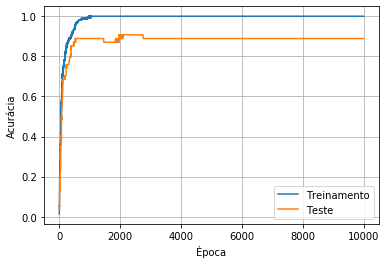

In [8]:
print_acc_results(history)

In [ ]:
legend = []
for i in range(1,6):
    with open('variacao_neuronios/'+str(i)+'_neurons.pickle', 'rb') as handle:
        history = pickle.load(handle)
        
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    legend = legend + ['Treinamento ' + str(i), 'Teste '+ str(i)]
    
plt.rcParams['figure.figsize'] = [10, 5]
plt.legend(legend, loc='best')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.grid()
plt.show()

In [ ]:
directory = 'Dados_continuo3'

dataset = pd.DataFrame()

files_list = os.listdir(directory)
    
stats = []
# all_dataframe = {}

for f in files_list:
    print(len(dataset))
    with open(directory+"/"+f) as file:
        lines = [line.strip() for line in file]
        lines = ast.literal_eval(lines[0])
        test = pd.DataFrame(lines)
#         d = {'media':test.mean(), 'desvio_padrao': test.std(), 'max': test.max(), 'min': test.min()}

#         stats.append(pd.DataFrame(d))
        dataset = dataset.append(test, ignore_index = True)

#         if letra not in all_dataframe:
#             all_dataframe[letra] = []
#         all_dataframe[letra].append(test)
dataset  = dataset/16384

In [ ]:
dif_df = dataset.diff(axis = 0, periods = 1) 

In [ ]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.plot(dif_df.iloc[:,:].pow(2).sum(axis=1))
plt.grid()
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.plot(dataset.iloc[:,:].pow(2).sum(axis=1))
plt.grid()
plt.show()

In [ ]:
directory = 'Dados_continuo4'

dataset = pd.DataFrame()

files_list = os.listdir(directory)
    
stats = []
# all_dataframe = {}

for f in files_list:
    print(len(dataset))
    with open(directory+"/"+f) as file:
        lines = [line.strip() for line in file]
        lines = ast.literal_eval(lines[0])
        test = pd.DataFrame(lines)
#         d = {'media':test.mean(), 'desvio_padrao': test.std(), 'max': test.max(), 'min': test.min()}

#         stats.append(pd.DataFrame(d))
        dataset = dataset.append(test, ignore_index = True)

#         if letra not in all_dataframe:
#             all_dataframe[letra] = []
#         all_dataframe[letra].append(test)
dataset  = dataset/16384

In [ ]:
dif_df = dataset.diff(axis = 0, periods = 1) 

In [ ]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.plot(dif_df.iloc[:,:].abs().sum(axis=1).rolling(window=15).mean())
plt.grid()
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.plot(dataset.iloc[:,:].abs().sum(axis=1).rolling(window=15).mean())
plt.grid()
plt.show()

In [ ]:
len(prevs)

In [ ]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.plot(prevs)
plt.grid()
plt.show()

In [ ]:
model = load_model('modelo_alfabeto_treinado.h5')

In [ ]:
# errors = get_incorrects(model, X_DT, y_DT)

p = model.predict(dataset)
    
# errors = []
# for i in range(len(data)):
#     equal = (np.where(labels[i] == np.amax(labels[i]))[0][0]) == (np.where(p[i] == np.amax(p[i])))[0][0]
#     if not equal:
#         print((np.where(labels[i] == np.amax(labels[i]))[0][0]), (np.where(p[i] == np.amax(p[i])))[0][0])
#         print()
#         errors.append(i)

# print(len(errors))

In [ ]:
prevs = []
for a in range(len(p)):
    prev = np.where(p[a] == np.amax(p[a]))[0][0]
    prevs.append(prev)

In [ ]:
prevs